###  Preparación de los datos

El objetivo de este script es prepara la información total en los formatos requeridos para la ejecución del modelo.

Considerando que existen variables numericas, categoricas ordinales y nominales.:

* Categoricas ordinales:  La variables categoricas tienen un orden específico a través del tipo "Category", si este orden no cumple con el entrenamiento no se puede aprovechar el modelo. Adicionalmente, el dataset puede no tener todas las categorias utilizadas en el entrenamiento lo que genera problemas al procesar la base y resultados inesperados

* Nominales: Se convierten en variables dummies, a través del proceso one hot encoder. Para garantizar el orden y cantidad de columnas generadas se carga el objeto creado en la fase de entrenamiento del modelo y se aplica sobre la base general a procesar.

* Se transforma y ejecuta la nueva base por tandas, se captura el valor pronosticado y real
* Se evaluan métricas de evaluación sobre la base general


* No olvidar procesar el estrato

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import random

pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from mlxtend.evaluate import lift_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score,roc_auc_score, f1_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime

from joblib import Parallel, delayed, dump, load
import gc
import pickle

### Carga elementos generadores

In [3]:
path_data = 'modeloEntrenado_old/'
file= f'GtableCategorical.csv'

In [4]:
GtableCategorical = pd.read_csv(f'{path_data}{file}', sep=',', decimal='.').set_index('Unnamed: 0')

In [5]:
#path_data = ''
file= f'GtableNominales.csv'

In [6]:
GtableNominales = pd.read_csv(f'{path_data}{file}', sep=',', decimal='.').set_index('Unnamed: 0')

In [7]:
GtableNominales

,DEPARTAMENTO,COD_PLAN_ACTUAL,MARKETING_NAME,MANUFACTURER
Unnamed: 0,,,,
0,BOGOTA D C,25017-4103,0,Samsung
1,ANTIOQUIA,0,Galaxy A21s,HUAWEI
2,CUNDINAMARCA,25867-4103,Galaxy A30s,Motorola
3,VALLE DEL CAUCA,25522-6734,HUAWEI Y9 Prime 2019,Redmi
4,BOYACA,24231-4103,Redmi Note 8,0


In [8]:
ruta_objeto = f"{path_data}class_ohe.pkl"
#class_ohe = load(ruta_objeto)
class_ohe = load(ruta_objeto)

In [9]:
colCatNom=['DEPARTAMENTO','TIPO_MUNICIPIO','MARKETING_NAME','MANUFACTURER','COD_PLAN_ACTUAL',
           'OPERADOR_4GBEST_DW','OPERADOR_4GBEST_UP','OPERADOR_4GBEST_LA',
           'OPERADOR_4GBEST_DB','OPERADOR_4GCLARO','OPERADOR_3GBEST_DW', 'OPERADOR_3GBEST_UP', 'OPERADOR_3GBEST_LA',
           'OPERADOR_3GBEST_DB', 'OPERADOR_3GCLARO', 'OPERADOR_CLARO']
colBinning=['DEPARTAMENTO','COD_PLAN_ACTUAL','MARKETING_NAME','MANUFACTURER']
colCatOrd=['COMPORTAMIENTO_PAGO','MIN_CALIFICACION_CREDITO','MAX_CALIFICACION_CREDITO',
           'TECH_EQUIPO','TECNOLOGIA_EQUIPO',
           'TENDENCIA_CHURN_GSM','TENDENCIA_CHURN_LTE','TENDENCIA_CHURN_UMTS',
           'TENDENCIA_DOWN_4G_CLARO','TENDENCIA_DOWN_4G_BEST',
           'TENDENCIA_LLAMADAS_GSM', 'TENDENCIA_LLAMADAS_UTMS','TENDENCIA_LLAMADAS_LTE',
           'CL_TASA_CHURN','CL_CHURN_LATENCIA_4G']

In [10]:
### cargar modelo
ruta_modelo = f"{path_data}modelLGBM2.pkl"
modelLGBM2 = load(ruta_modelo)

In [11]:
## variables para guardar resultados
predicciones={}
indexes={}
reales={}

### Tipos de Datos categoricos ordinales

In [12]:
for col in colCatOrd:
    GtableCategorical[col] = GtableCategorical[col].astype('category')

In [13]:
GtableCategorical

,COMPORTAMIENTO_PAGO,MIN_CALIFICACION_CREDITO,MAX_CALIFICACION_CREDITO,TECH_EQUIPO,TECNOLOGIA_EQUIPO,TENDENCIA_CHURN_GSM,TENDENCIA_CHURN_LTE,TENDENCIA_CHURN_UMTS,TENDENCIA_DOWN_4G_CLARO,TENDENCIA_DOWN_4G_BEST,TENDENCIA_LLAMADAS_GSM,TENDENCIA_LLAMADAS_UTMS,TENDENCIA_LLAMADAS_LTE,CL_TASA_CHURN,CL_CHURN_LATENCIA_4G
Unnamed: 0,,,,,,,,,,,,,,,
0,0,SIN_ESTUDIO,SIN_ESTUDIO,0,0,0,0,0,0,0,0,0,0,0,0
1,ALTO RIESGO,P-PREPAGO,P-PREPAGO,2G,2G,decreasing,decreasing,decreasing,decreasing,decreasing,decreasing,decreasing,no trend,B-B,B-B
2,REGULAR,7-POSPAGO,7-POSPAGO,3G,3G,no trend,no trend,no trend,no trend,no trend,no trend,no trend,0,B-A,B-A
3,BUENO,5-POSPAGO,5-POSPAGO,4G,LTE,increasing,increasing,increasing,increasing,increasing,increasing,increasing,0,A-B,0
4,MUY BUENO,E-POSPAGO,E-POSPAGO,0,4G,0,0,0,0,0,0,0,0,A-A,0
5,NUEVO,D-POSPAGO,D-POSPAGO,0,0,0,0,0,0,0,0,0,0,0,0
6,0,C-POSPAGO,C-POSPAGO,0,0,0,0,0,0,0,0,0,0,0,0
7,0,B-POSPAGO,B-POSPAGO,0,0,0,0,0,0,0,0,0,0,0,0
8,0,A-POSPAGO,A-POSPAGO,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
GtableCategorical['COMPORTAMIENTO_PAGO'].cat.reorder_categories(['0','ALTO RIESGO','REGULAR','BUENO','MUY BUENO','NUEVO'], inplace=True)
GtableCategorical['TENDENCIA_CHURN_GSM'].cat.reorder_categories(['0','decreasing','no trend','increasing'], inplace=True)
GtableCategorical['TENDENCIA_CHURN_LTE'].cat.reorder_categories(['0','decreasing','no trend','increasing'], inplace=True)
GtableCategorical['TENDENCIA_CHURN_UMTS'].cat.reorder_categories(['0','decreasing','no trend','increasing'], inplace=True)
GtableCategorical['TENDENCIA_DOWN_4G_CLARO'].cat.reorder_categories(['0','decreasing','no trend','increasing'], inplace=True)
GtableCategorical['TENDENCIA_DOWN_4G_BEST'].cat.reorder_categories(['0','decreasing','no trend','increasing'], inplace=True)
GtableCategorical['TENDENCIA_LLAMADAS_GSM'].cat.reorder_categories(['0','decreasing','no trend','increasing'], inplace=True)
GtableCategorical['TENDENCIA_LLAMADAS_UTMS'].cat.reorder_categories(['0','decreasing','no trend','increasing'], inplace=True)
GtableCategorical['TENDENCIA_LLAMADAS_LTE'].cat.reorder_categories(['0','no trend'], inplace=True)
GtableCategorical['MIN_CALIFICACION_CREDITO'].cat.reorder_categories(['SIN_ESTUDIO','P-PREPAGO','7-POSPAGO','5-POSPAGO','E-POSPAGO','D-POSPAGO','C-POSPAGO','B-POSPAGO','A-POSPAGO'], inplace=True)
GtableCategorical['MAX_CALIFICACION_CREDITO'].cat.reorder_categories(['SIN_ESTUDIO','P-PREPAGO','7-POSPAGO','5-POSPAGO','E-POSPAGO','D-POSPAGO','C-POSPAGO','B-POSPAGO','A-POSPAGO'], inplace=True)
GtableCategorical['TECH_EQUIPO'].cat.reorder_categories(['0','2G','3G','4G'], inplace=True)
GtableCategorical['TECNOLOGIA_EQUIPO'].cat.reorder_categories(['0','2G','3G','LTE','4G'], inplace=True)
GtableCategorical['CL_TASA_CHURN'].cat.reorder_categories(['0','B-B','B-A','A-B','A-A'], inplace=True)
GtableCategorical['CL_CHURN_LATENCIA_4G'].cat.reorder_categories(['0','B-B','B-A'], inplace=True)

In [15]:
GtableNominales

,DEPARTAMENTO,COD_PLAN_ACTUAL,MARKETING_NAME,MANUFACTURER
Unnamed: 0,,,,
0,BOGOTA D C,25017-4103,0,Samsung
1,ANTIOQUIA,0,Galaxy A21s,HUAWEI
2,CUNDINAMARCA,25867-4103,Galaxy A30s,Motorola
3,VALLE DEL CAUCA,25522-6734,HUAWEI Y9 Prime 2019,Redmi
4,BOYACA,24231-4103,Redmi Note 8,0


### Cargar datos

In [16]:
start = datetime.now()
path_data = ''
file= f'GAAVANZADA.TTA_ANALITICA_CAMBIO_EQUI_COMPLETA_FINANCIA_LIFT_202110.csv'
df = pd.read_csv(f'{path_data}{file}', sep='|', decimal='.',error_bad_lines=False)

Columns (0,48) have mixed types.Specify dtype option on import or set low_memory=False.


In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
EDAD_MESES,3330057.00,567.24,1015.36,-95726.90,379.00,498.06,649.23,24249.97
CANTIDAD_LINEAS,3347965.00,1.10,0.35,1.00,1.00,1.00,1.00,35.00
TIPO_IDENTIFICACION,3347965.00,1.01,0.15,1.00,1.00,1.00,1.00,4.00
ANTIGUEDAD_MESES,3347965.00,51.47,53.04,0.13,9.77,32.11,76.13,220.13
VLR_CFM,3347965.00,46170.75,23216.59,0.00,32382.37,40102.40,51661.57,3018493.33
CANT_MB_INC_PLAN,3347965.00,2823154.97,17525609.27,0.00,15360.00,25600.00,30720.00,3499999965.00
NUM_UPGRADES,3347965.00,0.02,0.14,0.00,0.00,0.00,0.00,7.00
NUM_DOWNGRADES,3347965.00,0.08,0.29,0.00,0.00,0.00,0.00,12.00
NUM_PARALELO,3347965.00,0.00,0.02,0.00,0.00,0.00,0.00,3.00
FACTURADO_CFM_MM1,3347965.00,38822.96,33631.78,-223600.04,0.00,39900.00,55900.01,3636500.00


In [18]:
df.head(5)

,IDENTIFICACION,EDAD_MESES,CANTIDAD_LINEAS,TIPO_IDENTIFICACION,ANTIGUEDAD_MESES,VLR_CFM,CANT_MB_INC_PLAN,NUM_UPGRADES,NUM_DOWNGRADES,NUM_PARALELO,FACTURADO_CFM_MM1,FACTURADO_CFM_MM2,FACTURADO_CFM_MM3,FACTURADO_CFM_MM4,FACTURADO_CFM_MM5,FACTURADO_CFM_MM6,FACTURADO_ADICIONALES_MM1,FACTURADO_ADICIONALES_MM2,FACTURADO_ADICIONALES_MM3,FACTURADO_ADICIONALES_MM4,FACTURADO_ADICIONALES_MM5,FACTURADO_ADICIONALES_MM6,NUM_SUSPENSIONES,MAX_EDAD_MORA_MM1,MAX_EDAD_MORA_MM2,MAX_EDAD_MORA_MM3,MAX_EDAD_MORA_MM4,CONSUMO_TOTAL_MB_MM1,CONSUMO_TOTAL_MB_MM2,CONSUMO_TOTAL_MB_MM3,CONSUMO_TOTAL_MB_MM4,MIN_ENTRANTES_MM1,MIN_SALIENTES_MM1,MIN_ENTRANTES_MM2,MIN_SALIENTES_MM2,MIN_ENTRANTES_MM3,MIN_SALIENTES_MM3,MIN_ENTRANTES_MM4,MIN_SALIENTES_MM4,NUM_RETENCION,DIAS_IMEI_ACTUAL,DIAS_ANTIGUEDAD_IMEI,CANTIDAD_CAMBIOS_EQUIPO,COD_MIN_CALIFICACION_CREDITO,COD_MAX_CALIFICACION_CREDITO,DEPARTAMENTO,TIPO_MUNICIPIO,INICIO_CICLO,ESTRATO,SCORE_VOLUNTARIO,SCORE_INVOLUNTARIO,SCORE_PORTABILIDAD,COMPORTAMIENTO_PAGO,MIN_CALIFICACION_CREDITO,MAX_CALIFICACION_CREDITO,TECH_EQUIPO,MANUFACTURER_OR_APPLICANT_MM1,MANUFACTURER_OR_APPLICANT_MM2,MSISDN,TAC,TECNOLOGIA_EQUIPO,SITIO,CO_ID,TELE_NUMB,MARKETING_NAME,MANUFACTURER,COD_PLAN_ACTUAL,ANTIUEDAD_PLAN_ACTUAL_MESES,TENDENCIA_CHURN_GSM,TENDENCIA_CHURN_LTE,TENDENCIA_CHURN_UMTS,TENDENCIA_DOWN_4G_CLARO,TENDENCIA_DOWN_4G_BEST,OPERADOR_4GBEST_DW,DOWNLOAD_KBPS_4GBEST_DW,OPERADOR_4GBEST_UP,UPLOAD_KBPS_4GBEST_UP,OPERADOR_4GBEST_LA,LATENCY_4GBEST_LA,OPERADOR_4GBEST_DB,DBM_4GBEST_DB,OPERADOR_4GCLARO,DOWNLOAD_KBPS_4GCLARO,UPLOAD_KBPS_4GCLARO,LATENCY_4GCLARO,DBM_4GCLARO,DIFERENCIA_MEJOR_4G_DOWN,DIFERENCIA_MEJOR_4G_UP,DIFERENCIA_MEJOR_4G_LAT,DIFERENCIA_MEJOR_4G_DBM,OPERADOR_3GBEST_DW,DOWNLOAD_KBPS_3GBEST_DW,OPERADOR_3GBEST_UP,UPLOAD_KBPS_3GBEST_UP,OPERADOR_3GBEST_LA,LATENCY_3GBEST_LA,OPERADOR_3GBEST_DB,DBM_3GBEST_DB,OPERADOR_3GCLARO,DOWNLOAD_KBPS_3GCLARO,UPLOAD_KBPS_3GCLARO,LATENCY_3GCLARO,DBM_3GCLARO,DIFERENCIA_MEJOR_3G_DOWN,DIFERENCIA_MEJOR_3G_UP,DIFERENCIA_MEJOR_3G_LAT,DIFERENCIA_MEJOR_3G_DBM,OPERADOR_CLARO,TENDENCIA_LLAMADAS_GSM,TENDENCIA_LLAMADAS_UTMS,TENDENCIA_LLAMADAS_LTE,GSM,LTE,UMTS,SOLO_DATOS,SOLO_VOZ,VOZ_DATOS,LINEAS_TOTALES,CANTIDAD_USER,CANT_POST,CANT_PREP,TASA_CHURN,CONTEO_RECLAMACIONES,TASA_SARA,TASA_RECLAMA,W_TASA_CHURN,CL_TASA_CHURN,CL_CHURN_LATENCIA_4G,COMPRAS_TERMINALES_MM1,COMPRAS_TERMINALES_MM2,COMPRAS_TERMINALES_MM3,COMPRAS_TERMINALES_MM4,COMPRAS_TECNOLOGIA_MM1,COMPRAS_TECNOLOGIA_MM2,COMPRAS_TECNOLOGIA_MM3,COMPRAS_TECNOLOGIA_MM4
0,28534191,901.52,1,1,60.33,51661.57,30720,0,1,0,61900.00,82900.01,82900.01,82900.01,82900.01,82900.01,54.24,0.00,0.00,0.00,0.00,0.00,0,0,30.00,NaN,NaN,2034.00,3628.00,836.00,300.00,763.00,762.00,616.00,742.00,1129.00,1153.00,1051.00,1597.00,0,1825.00,1825.00,1.00,1,1,TOLIMA,CABECERA,11,4,0.04,0.01,0.04,BUENO,E-POSPAGO,E-POSPAGO,4G,NaN,NaN,573002006011.00,35332595.00,4G,IBG.RB CLUB CAMPESTRE,219555974.00,573002006011.00,Samsung SM-J700M,Samsung,25207-6734,0.68,no trend,no trend,no trend,no trend,no trend,TIGO,25941.86,TIGO,16813.77,TIGO,27.39,MOVISTAR,-97.66,CLARO,15027.47,4041.00,35.34,-101.25,-0.42,-0.76,0.29,0.04,TIGO,16125.00,MOVISTAR,1876.62,MOVISTAR,44.25,WOM,-83.00,CLARO,1451.75,1521.50,57.50,-95.00,-0.91,-0.19,0.30,0.14,CLARO,no trend,no trend,no trend,28.00,1.00,220.00,30.00,1.00,218.00,249.00,7816.33,2172.89,5643.44,0.03,15.00,0.01,0.00,0.00,B-B,B-B,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,37290849,459.00,1,1,62.87,24954.46,10240,0,0,0,29900.00,29900.00,29900.00,29900.00,29900.00,29900.00,58.74,19.62,58.71,39.19,78.46,39.40,0,30,30.00,30.00,30.00,2273.00,3440.00,3041.00,4254.00,218.00,393.00,162.00,567.00,350.00,693.00,355.00,779.00,0,455.00,1679.00,4.00,1,1,N DE SANTANDER,CABECERA,14,1,0.08,0.02,0.04,REGULAR,E-POSPAGO,E-POSPAGO,4G,NaN,NaN,573002013344.00,35735007.00,4G,NOR.LA PARADA,214736248.00,573002013344.00,Galaxy S7 SM-G930F,Samsung,25017-4103,16.58,no trend,no trend,no trend,no trend,no trend,TIGO,32904.67,TIGO,21871.83,TIGO,38.67,AVANTEL,-73.35,CLARO,4903.29,8765.74,76.48,-92.85,-

In [19]:
df['MANUFACTURER_OR_APPLICANT_MM1'].value_counts()

Xiaomi Communications Co Ltd                           26255
Samsung Korea                                          23203
Motorola Mobility LLC, a Lenovo Company                15167
Vivo Mobile Communication Co Ltd                        4650
Guangdong Oppo Mobile Telecommunications Corp Ltd       4404
HMD Global Oy                                           2202
Huawei Device Company Limited                           1977
Realme Chongqing Mobile Telecommunications Corp Ltd     1494
Apple Inc                                                943
TCL Communication Ltd                                    518
Honor Device Company Limited                             281
HUAWEI Technologies Co Ltd                               259
ZTE Corporation                                          245
LG Electronics Inc.                                        5
Senwa Mexico S.A. de C.V.                                  1
Name: MANUFACTURER_OR_APPLICANT_MM1, dtype: int64

In [20]:
df['MANUFACTURER_OR_APPLICANT_MM2'].value_counts()

Samsung Korea                                          6308
Xiaomi Communications Co Ltd                           4902
Motorola Mobility LLC, a Lenovo Company                3452
Vivo Mobile Communication Co Ltd                       1127
Guangdong Oppo Mobile Telecommunications Corp Ltd       983
HMD Global Oy                                           616
Huawei Device Company Limited                           590
Realme Chongqing Mobile Telecommunications Corp Ltd     273
Apple Inc                                               273
Honor Device Company Limited                            126
TCL Communication Ltd                                   114
ZTE Corporation                                          67
HUAWEI Technologies Co Ltd                               58
LG Electronics Inc.                                       4
Senwa Mexico S.A. de C.V.                                 2
Name: MANUFACTURER_OR_APPLICANT_MM2, dtype: int64

In [21]:
#desc=df.describe()
dup=df[["IDENTIFICACION","MANUFACTURER_OR_APPLICANT_MM1"]].groupby(by=["IDENTIFICACION"], dropna=False).count()
dup.sort_values('MANUFACTURER_OR_APPLICANT_MM1', ascending=False).head(10)
dup.reset_index().groupby(by=["MANUFACTURER_OR_APPLICANT_MM1"]).count()
#  Numero Identificaciones
dup.reset_index().groupby(by=["MANUFACTURER_OR_APPLICANT_MM1"]).count().sum()


IDENTIFICACION    3344868
dtype: int64

In [22]:
len(df)

3347965

### Etiquetas datos

In [23]:
# llenar nan
df['MANUFACTURER_OR_APPLICANT_MM1'].fillna("SinEquipo", inplace=True)
df['MANUFACTURER_OR_APPLICANT_MM2'].fillna("SinEquipo", inplace=True)
df[['MANUFACTURER_OR_APPLICANT_MM1']].value_counts()
df[['MANUFACTURER_OR_APPLICANT_MM1']].isna().sum()
df[['MANUFACTURER_OR_APPLICANT_MM2']].value_counts()
df[['MANUFACTURER_OR_APPLICANT_MM2']].isna().sum()
E_MF_MM1=df[['IDENTIFICACION','MANUFACTURER_OR_APPLICANT_MM1']]
E_MF_MM2=df[['IDENTIFICACION','MANUFACTURER_OR_APPLICANT_MM2']]

In [24]:
E_MF_MM1_T=pd.pivot_table(E_MF_MM1, index='IDENTIFICACION', columns='MANUFACTURER_OR_APPLICANT_MM1', aggfunc=len, fill_value=0)
E_MF_MM2_T=pd.pivot_table(E_MF_MM2, index='IDENTIFICACION', columns='MANUFACTURER_OR_APPLICANT_MM2', aggfunc=len, fill_value=0)
cols=list(set(np.concatenate((E_MF_MM1_T.columns.values,E_MF_MM2_T.columns.values))))
E_MF_MM1_T['HMD Global Oy'].head(2)
(E_MF_MM1_T['HMD Global Oy']+E_MF_MM2_T['HMD Global Oy']).head(2)
E_MF=(E_MF_MM1_T+E_MF_MM2_T)
E_MF["Total"]=E_MF.drop('SinEquipo',1).sum(axis=1)
for col in cols+['Total'] :
    E_MF[col]=np.where(E_MF[col]>0,1,0)

### Reducción por IDENTIFICICACIÓN

In [25]:
# ### Reducción por IDENTIFICICACIÓN
variableRechazadas=['MSISDN','TAC','CO_ID','TELE_NUMB','MANUFACTURER_OR_APPLICANT_MM1','MANUFACTURER_OR_APPLICANT_MM2','SITIO']
tablaAnalisis=df.copy()
tablaAnalisis['ESTRATO'].value_counts()
tablaAnalisis['ESTRATO'].isna().sum()
tablaAnalisis['ESTRATO']=tablaAnalisis['ESTRATO'].fillna(0)
tablaAnalisis['ESTRATO']=np.where(tablaAnalisis['ESTRATO']=='nulo',0,tablaAnalisis['ESTRATO'])
tablaAnalisis['ESTRATO']=tablaAnalisis['ESTRATO'].astype(int)
tablaAnalisis=tablaAnalisis.drop(columns=variableRechazadas).drop_duplicates()

In [26]:
tablaAnalisis.count()
tablaAnalisis.set_index('IDENTIFICACION', inplace=True)

In [27]:
tablaAnalisis=tablaAnalisis.fillna(0)

In [28]:
colCategoricas=tablaAnalisis.select_dtypes('object').columns
colNumericas=tablaAnalisis.select_dtypes(exclude='object').columns

In [29]:
for col in colCategoricas:
        #dm_traindf[dm_class_input].applymap(str)
        tablaAnalisis[col]=tablaAnalisis[[col]].applymap(str) 

## Nominales 
se puede hacer una vez al inicio

In [30]:
## hacer binning
for col in colBinning:    
    auxBin=GtableNominales[col].unique()    
    tablaAnalisis[col]=np.where(tablaAnalisis[col].isin(auxBin), tablaAnalisis[col] , 'OTRO')

In [31]:
colsNotNoms=tablaAnalisis.drop(columns=colCatNom).columns.values.tolist()

In [32]:
colDummies=class_ohe.get_feature_names(colCatNom)

In [33]:
colsFinal=colsNotNoms
colsFinal.extend(colDummies)

#### Predicciones

In [34]:
#num_registros=len(tablaAnalisis_base)
num_registros=len(tablaAnalisis)

In [35]:
tablaAnalisis_base=tablaAnalisis

In [36]:
predicciones={}
indexes={}
reales={}

In [37]:
for i in range(0,6):
    print(i)

0
1
2
3
4
5


In [38]:
imax=len(tablaAnalisis_base)//(10**6)
imax

3

In [39]:
for i in range(0,imax+1):
    i_inicial=i*1000000
    i_final=min((i+1)*1000000,num_registros)
    tablaAnalisis=tablaAnalisis_base.iloc[i_inicial:i_final]
    tablaAnalisis_class_ohe = class_ohe.transform(tablaAnalisis[colCatNom]).toarray()
    tablaAnalisisFinal=pd.DataFrame(np.concatenate((tablaAnalisis.drop(columns=colCatNom), tablaAnalisis_class_ohe), axis=1),index=tablaAnalisis.index, columns=colsFinal)
    tablaAnalisisComp=tablaAnalisisFinal.join(E_MF)
    #tipos de dato
    for col in colCatOrd:
        tablaAnalisisComp[col]=tablaAnalisisComp[col].astype(GtableCategorical.dtypes[col])
    for col in colCatOrd:
        tablaAnalisisComp[col]=tablaAnalisisComp[col].cat.codes   
    for col in colDummies:
        tablaAnalisisComp[col]=tablaAnalisisComp[col].astype('int64')
    for col in colNumericas:
        tablaAnalisisComp[col]=tablaAnalisisComp[col].astype(tablaAnalisis.dtypes[col])
    # Prediccion final
    pred_final=modelLGBM2.predict(tablaAnalisisComp[colsFinal])
    predicciones[i]=pred_final
    indexes[i]=tablaAnalisisComp.index.values
    reales[i]= tablaAnalisisComp[['Total']]
    
    del tablaAnalisisFinal
    del tablaAnalisisComp        
    gc.collect()
        

In [40]:
reales[0].head(2)

,Total
IDENTIFICACION,
28534191,0
37290849,0


In [41]:
type(predicciones[0])

numpy.ndarray

In [42]:
## Unir respuesta
reales_total=reales[0]
predicciones_total=predicciones[0]

In [43]:
len(reales_total)

1000000

In [44]:
len(predicciones_total)

1000000

In [45]:
for i in range(1,imax+1):
    reales_total=reales_total.append(reales[i])
    predicciones_total=np.append(predicciones_total,predicciones[i])    

In [46]:
#val nulls

In [47]:
reales_total['Total'].head(2)

IDENTIFICACION
28534191    0
37290849    0
Name: Total, dtype: int32

In [48]:
reales_total['Total'].head(2)

IDENTIFICACION
28534191    0
37290849    0
Name: Total, dtype: int32

In [49]:
reales_total_C=reales_total['Total'].to_numpy()

In [50]:
reales_total.isna().sum()

Total    0
dtype: int64

In [51]:
for i in range (1,10):
    print(i/10)
    pred_C=predicciones_total>=i/10
    #print('pred_C',len(pred_C))
    #print('reales',len(reales_total))
    print(f'precision: {round(precision_score(reales_total_C, pred_C),5)}')
    print(f'recall: {round(recall_score(reales_total_C, pred_C),5)}')
    print(f'AUC: {round(roc_auc_score(reales_total_C,pred_C),5)}')
    print(f'LIFT: {round(lift_score(reales_total_C,pred_C),5)}') 
    matrizConfucion = confusion_matrix(reales_total_C, pred_C)
    print(matrizConfucion)

0.1
precision: 0.03047
recall: 0.98168
AUC: 0.52838
LIFT: 1.05949
[[ 243912 3004747]
 [   1763   94446]]
0.2
precision: 0.03397
recall: 0.89964
AUC: 0.57097
LIFT: 1.18095
[[ 787137 2461522]
 [   9656   86553]]
0.3
precision: 0.03932
recall: 0.72356
AUC: 0.60003
LIFT: 1.36713
[[1547988 1700671]
 [  26596   69613]]
0.4
precision: 0.04698
recall: 0.45018
AUC: 0.58985
LIFT: 1.6332
[[2369987  878672]
 [  52898   43311]]
0.5
precision: 0.05828
recall: 0.16511
AUC: 0.54305
LIFT: 2.02624
[[2991986  256673]
 [  80324   15885]]
0.6
precision: 0.07822
recall: 0.02329
AUC: 0.50758
LIFT: 2.71945
[[3222250   26409]
 [  93968    2241]]
0.7
precision: 0.09011
recall: 0.00106
AUC: 0.50037
LIFT: 3.13269
[[3247629    1030]
 [  96107     102]]
0.8
precision: 0.05556
recall: 1e-05
AUC: 0.5
LIFT: 1.93148
[[3248642      17]
 [  96208       1]]
0.9


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


precision: 0.0
recall: 0.0
AUC: 0.5
LIFT: nan


invalid value encountered in double_scalars


[[3248659       0]
 [  96209       0]]


In [52]:
def plot_Lift_curve(y_val, y_pred, step=0.01):    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

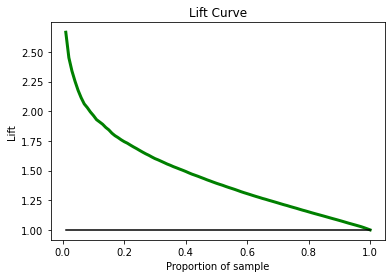

In [53]:
plot_Lift_curve(reales_total_C,predicciones_total)

In [53]:
type(reales_total)

pandas.core.frame.DataFrame

In [54]:
len(predicciones_total)

3000000

In [55]:
len(reales_total)

3000000

###  Corte para separar los casos de cambio de equipo 0.5